In [14]:
# === „É©„Ç§„Éñ„É©„É™Ë™≠„ÅøËæº„Åø ===
import torch
from pathlib import Path

# === „Éè„Ç§„Éë„Éº„Éë„É©„É°„Éº„ÇøË®≠ÂÆö ===
IMAGE_SIZE = 128
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

# === „Éá„Éê„Ç§„ÇπË®≠ÂÆöÔºàMacÂØæÂøúÔºâ ===
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"‚úÖ Using device: {device}")

‚úÖ Using device: mps


In [15]:
# === „É©„Ç§„Éñ„É©„É™Ë™≠„ÅøËæº„Åø ===
import pandas as pd
from pathlib import Path

# === „Éë„ÇπË®≠ÂÆö ===
DATA_DIR = Path("../../data/various-face-rank")
CSV_PATH = DATA_DIR / "metadata.csv"
IMG_DIR = DATA_DIR / "images"

# === CSVË™≠„ÅøËæº„Åø ===
df = pd.read_csv(CSV_PATH)

# === ÂØæË±°Âàó„ÅÆÁµû„ÇäËæº„ÅøÔºàid„Å®rank„ÅÆ„ÅøÔºâ===
df = df[["id", "rank"]].copy()

# === ÁîªÂÉè„Éï„Ç°„Ç§„É´„ÅÆ„Éë„Çπ„Çí‰ΩúÊàêÔºàÂ≠òÂú®„ÉÅ„Çß„ÉÉ„ÇØ„ÅØÂà•ÈÄîÂèØÔºâ===
df["filename"] = df["id"].apply(lambda x: f"image_{int(x):04d}.png")
df["filepath"] = df["filename"].apply(lambda x: IMG_DIR / x)

print("‚úÖ „Éá„Éº„Çø„Éï„É¨„Éº„É†„ÅÆÊ∫ñÂÇôÂÆå‰∫Ü")
print(df.head())

‚úÖ „Éá„Éº„Çø„Éï„É¨„Éº„É†„ÅÆÊ∫ñÂÇôÂÆå‰∫Ü
   id  rank        filename                                           filepath
0   0     1  image_0000.png  ../../data/various-face-rank/images/image_0000...
1   1     3  image_0001.png  ../../data/various-face-rank/images/image_0001...
2   2     4  image_0002.png  ../../data/various-face-rank/images/image_0002...
3   3     5  image_0003.png  ../../data/various-face-rank/images/image_0003...
4   4     6  image_0004.png  ../../data/various-face-rank/images/image_0004...


In [16]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import torch

class RankDataset(Dataset):
    def __init__(self, df, image_size=128):
        self.df = df.reset_index(drop=True)
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # ÁîªÂÉèË™≠„ÅøËæº„Åø„Å®Â§âÊèõ
        image = Image.open(row["filepath"]).convert("RGB")
        image = self.transform(image)

        # „É©„Éô„É´„ÅØ rank „ÅÆ„Åø
        label = torch.tensor([row["rank"]], dtype=torch.float32)

        return image, label

In [18]:
# === ÂøÖË¶Å„Å™„É©„Ç§„Éñ„É©„É™ ===
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# === „É©„É≥„Ç≠„É≥„Ç∞Ê≠£Ë¶èÂåñÁî®„ÅÆÈñ¢Êï∞ ===
def assign_relative_score(df_subset):
    df_sorted = df_subset.sort_values("rank").reset_index(drop=True).copy()
    df_sorted["relative_score"] = df_sorted.index / (len(df_sorted) - 1)
    return df_sorted

# === „Éá„Éº„ÇøÂàÜÂâ≤ ===
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

# === „É©„É≥„Ç≠„É≥„Ç∞„Çí„Åù„Çå„Åû„Çå„ÅßÂÜçÊßãÊàêÔºàÈ†Ü‰Ωç„Åã„Çâ 0„Äú1„Å´Ê≠£Ë¶èÂåñÔºâ===
df_train = assign_relative_score(df_train)
df_val = assign_relative_score(df_val)

# === DataSet„ÅÆÂÆöÁæ©Ôºàrank‰∫àÊ∏¨Áî®Ôºâ===
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import torch

class RankDataset(Dataset):
    def __init__(self, df, image_size=128):
        self.df = df.reset_index(drop=True)
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["filepath"]).convert("RGB")
        image = self.transform(image)
        label = torch.tensor([row["relative_score"]], dtype=torch.float32)
        return image, label

# === DataLoader ‰ΩúÊàê ===
train_dataset = RankDataset(df_train, image_size=IMAGE_SIZE)
val_dataset = RankDataset(df_val, image_size=IMAGE_SIZE)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"‚úÖ train: {len(train_dataset)}‰ª∂, val: {len(val_dataset)}‰ª∂")

‚úÖ train: 80‰ª∂, val: 20‰ª∂


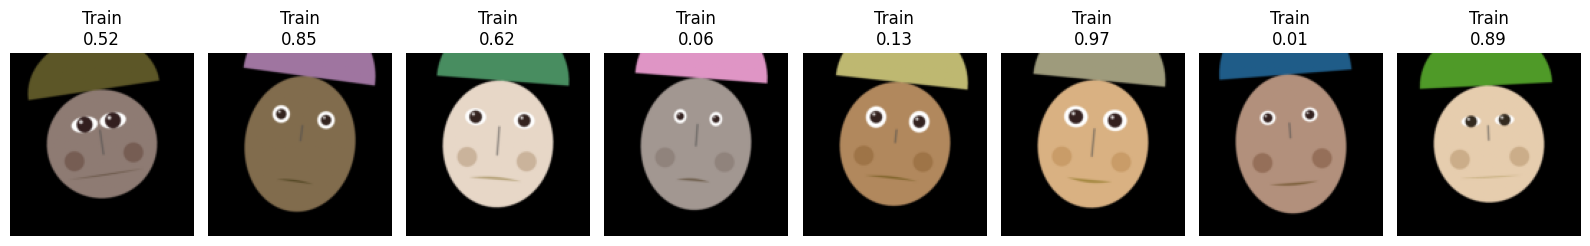

In [20]:
# üîç Train„Çª„ÉÉ„Éà„ÅÆ„Çµ„É≥„Éó„É´ÂèØË¶ñÂåñ
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))
num_samples = min(len(images), 8)
fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2.5))

for i in range(num_samples):
    ax = axes[i]
    img = images[i].permute(1, 2, 0).numpy()
    score = labels[i].item()
    ax.imshow(img)
    ax.set_title(f"Train\n{score:.2f}")
    ax.axis("off")

plt.tight_layout()
plt.show()

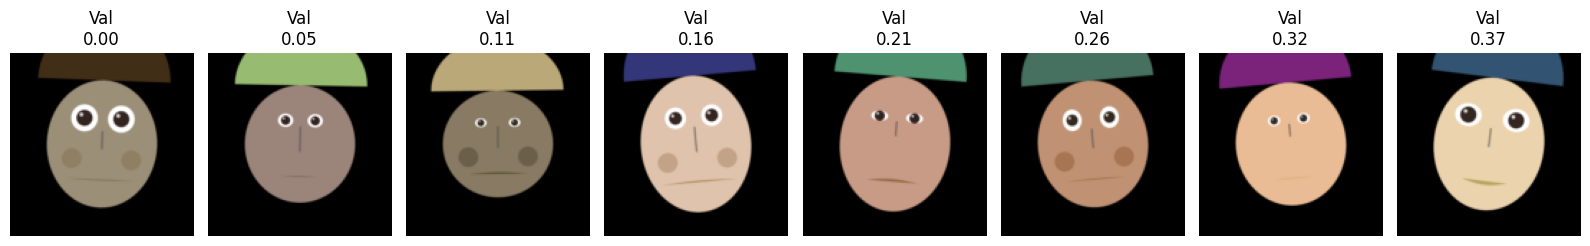

In [21]:
# üîç Val„Çª„ÉÉ„Éà„ÅÆ„Çµ„É≥„Éó„É´ÂèØË¶ñÂåñ
images, labels = next(iter(val_loader))
num_samples = min(len(images), 8)
fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2.5))

for i in range(num_samples):
    ax = axes[i]
    img = images[i].permute(1, 2, 0).numpy()
    score = labels[i].item()
    ax.imshow(img)
    ax.set_title(f"Val\n{score:.2f}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class RankingCNN(nn.Module):
    def __init__(self, image_size=128):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        flatten_size = 32 * (image_size // 4) * (image_size // 4)
        self.fc1 = nn.Linear(flatten_size, 64)
        self.fc2 = nn.Linear(64, 1)  # Âá∫Âäõ„ÅØ„Çπ„Ç´„É©„ÉºÔºà„É©„É≥„Ç≠„É≥„Ç∞„Çπ„Ç≥„Ç¢Ôºâ

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 ‚Üí ReLU ‚Üí Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 ‚Üí ReLU ‚Üí Pool
        x = x.view(x.size(0), -1)             # Flatten
        x = F.relu(self.fc1(x))               # FC1 ‚Üí ReLU
        return self.fc2(x).squeeze(1)         # FC2 ‚Üí Âá∫Âäõ (B,) „Å´„Åô„Çã

In [23]:
import wandb
from tqdm import tqdm
import torch.nn as nn

# === wandb ÂàùÊúüÂåñ ===
wandb.init(
    project="parametric-visual-learning",
    name="rank-predict-v1",
    config={
        "epochs": NUM_EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "image_size": IMAGE_SIZE
    }
)

# === „É¢„Éá„É´Ê∫ñÂÇô ===
model = RankingCNN(image_size=IMAGE_SIZE).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
val_losses = []

# === Â≠¶Áøí„É´„Éº„Éó ===
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * images.size(0)
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # === Ê§úË®º„É´„Éº„Éó ===
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item() * images.size(0)

    avg_val_loss = total_val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    # === „É≠„Ç∞Ë®òÈå≤ ===
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss
    })

    print(f"[{epoch+1}] üü¢ Train Loss: {avg_train_loss:.4f} | üîµ Val Loss: {avg_val_loss:.4f}")

wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kimurakoya (ritsumeikan-math). Use `wandb login --relogin` to force relogin


Epoch 1/10:   0%|          | 0/3 [00:00<?, ?it/s]/opt/homebrew/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/10:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2/3 [00:03<00:01,  1.54s/it, loss=1.16] /opt/homebrew/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:04<00:00,  1.49s/it, loss=0.147]
/opt/homebrew/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarni

[1] üü¢ Train Loss: 0.5887 | üîµ Val Loss: 0.2492


Epoch 2/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:01<00:00,  1.64it/s, loss=0.173]


[2] üü¢ Train Loss: 0.2350 | üîµ Val Loss: 0.1588


Epoch 3/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:01<00:00,  2.23it/s, loss=0.0745]


[3] üü¢ Train Loss: 0.1328 | üîµ Val Loss: 0.0960


Epoch 4/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:01<00:00,  2.47it/s, loss=0.0778]


[4] üü¢ Train Loss: 0.0882 | üîµ Val Loss: 0.0965


Epoch 5/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:01<00:00,  2.45it/s, loss=0.0997]


[5] üü¢ Train Loss: 0.0894 | üîµ Val Loss: 0.0932


Epoch 6/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:01<00:00,  2.53it/s, loss=0.0605]


[6] üü¢ Train Loss: 0.0852 | üîµ Val Loss: 0.0950


Epoch 7/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:01<00:00,  2.16it/s, loss=0.0861]


[7] üü¢ Train Loss: 0.0912 | üîµ Val Loss: 0.0953


Epoch 8/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:01<00:00,  2.41it/s, loss=0.0933]


[8] üü¢ Train Loss: 0.0911 | üîµ Val Loss: 0.0934


Epoch 9/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:01<00:00,  2.62it/s, loss=0.125] 


[9] üü¢ Train Loss: 0.0873 | üîµ Val Loss: 0.0927


Epoch 10/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:01<00:00,  2.46it/s, loss=0.0881]


[10] üü¢ Train Loss: 0.0867 | üîµ Val Loss: 0.0929


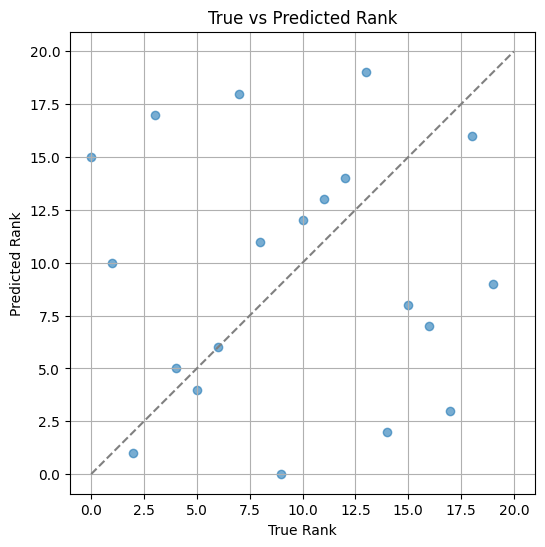

In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt

model.eval()
true_rank_scores = []
predicted_rank_scores = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        predictions = model(images).cpu().numpy().flatten()
        true_scores = labels[:, 0].cpu().numpy()  # rank„Çπ„Ç≥„Ç¢„Å†„Åë

        predicted_rank_scores.extend(predictions)
        true_rank_scores.extend(true_scores)

# === numpyÂåñ ===
true_rank_scores = np.array(true_rank_scores)
predicted_rank_scores = np.array(predicted_rank_scores)

# === „É©„É≥„Ç≠„É≥„Ç∞„ÇíÁÆóÂá∫ÔºàÂ∞è„Åï„ÅÑÂÄ§ = ‰∏ä‰ΩçÔºâ===
true_ranks = true_rank_scores.argsort().argsort()
pred_ranks = predicted_rank_scores.argsort().argsort()

# === Êï£Â∏ÉÂõ≥„Åß„Éó„É≠„ÉÉ„Éà ===
plt.figure(figsize=(6, 6))
plt.scatter(true_ranks, pred_ranks, alpha=0.6)
plt.plot([0, len(true_ranks)], [0, len(true_ranks)], linestyle="--", color="gray")
plt.xlabel("True Rank")
plt.ylabel("Predicted Rank")
plt.title("True vs Predicted Rank")
plt.grid(True)
plt.axis("equal")
plt.show()

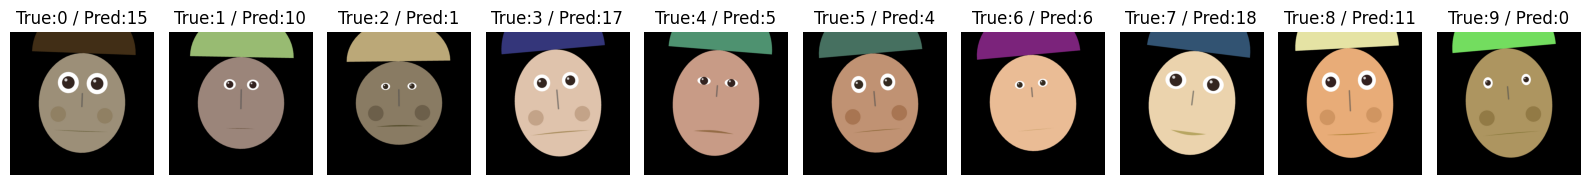

In [28]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# === Ë©ï‰æ°„É¢„Éº„Éâ„Å´Âàá„ÇäÊõø„Åà ===
model.eval()

# === ‰∫àÊ∏¨„Å®Ê≠£Ëß£„ÅÆ„É™„Çπ„Éà„ÇíÁî®ÊÑè ===
true_scores = []
pred_scores = []
filepaths = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images).cpu()  # (B, 1)
        labels = labels.cpu()

        for i in range(images.size(0)):
            pred = outputs[i].item() if outputs[i].ndim == 0 else outputs[i][0].item()
            true = labels[i].item() if labels[i].ndim == 0 else labels[i][0].item()
            pred_scores.append(pred)
            true_scores.append(true)
            filepaths.append(val_dataset.df.iloc[len(true_scores)-1]["filepath"])

# === numpy „Å´Â§âÊèõ„Åó„Å¶„ÇΩ„Éº„Éà ===
true_scores = np.array(true_scores)
pred_scores = np.array(pred_scores)

true_ranks = true_scores.argsort().argsort()  # È†Ü‰ΩçÔºàÂ∞è„Åï„ÅÑÂÄ§„Åå‰∏ä‰ΩçÔºâ
pred_ranks = pred_scores.argsort().argsort()

# === ‰∏ä‰ΩçN‰ª∂„ÇíÂèØË¶ñÂåñ ===
N = 10
top_idx = np.argsort(true_ranks)[:N]

plt.figure(figsize=(16, 4))
for i, idx in enumerate(top_idx):
    img = Image.open(filepaths[idx]).convert("RGB")

    plt.subplot(1, N, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True:{true_ranks[idx]} / Pred:{pred_ranks[idx]}")
plt.tight_layout()
plt.show()